# Introduction and Usage Guidelines

This notebook is designed as a base for analysis for Trackmania's physics. 

I'm running a small web server that collects and distributes collected map data from users using the Gigachad Collector plugin. 

(The 'in' section of the API is used by the GigaChad Collector (GCC) from within Trackmania.)

In [8]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

# optional - makes plots pop out. highly recommended. disabled for rendering in git
%matplotlib qt

# no trailing slash
url_prod = "http://gigachad.justinjschmitz.com:21532";
url_dev = "http://localhost:8080";

SERVER_PATH = url_prod

SWAGGER_PATH = f"{SERVER_PATH}/swagger-ui/index.html"

print(f"Current documentation page: {SWAGGER_PATH}")


Current documentation page: http://gigachad.justinjschmitz.com:21532/swagger-ui/index.html


## Data Selection

### "Maptags" vs "Runkeys" 

This is kind of an arbitrary convention, but:
* Map tags are for general surface use. 
* Runkeys are for specific study use. 

E.g., if you wanted to just look at how the stadium car drives on dirt, then you can pull the map tag 'stadium - dirt' and you'll have all that data. 

But, if you were doing some novel study (like trying to 2 wheel the rally car, or something) and wanted *just* that data, then make sure you set that as the the underlying runkey. That way, you're not pulling in more than you need to. 



In [86]:
maptags = requests.get(f"{SERVER_PATH}/out/maptag")
runkeys = requests.get(f"{SERVER_PATH}/out/runkey")
maptags_df = pd.json_normalize(maptags.json())
runkeys_df = pd.json_normalize(runkeys.json())
display(maptags_df)
display(runkeys_df)

# change these values with 'tag' and 'name' respectively

# 'legacy' for all of my old training data 
# these frames can be hard to work with
SELECTED_MAPTAG = 'tarmac - stadium' 
SELECTED_RUNKEY = 'default'


,mtId,mapUuid,tag,username
0,2,bu5OUM_XDFQ7w_vnhQOopNsyJQ8,dirt - stadium,sgt_bigbird
1,3,nDqOzuoWkPUJ9m74q0ihDVlTFn7,dirt - snow,sgt_bigbird
2,4,OuHxc71KtYLTkb7r6AmJcHCbbz8,dirt - rally,sgt_bigbird
3,5,M92iB3BWeAsGChHVL6QqqtAnNC6,dirt - desert,sgt_bigbird
4,6,LEGACY,legacy,sgt_bigbird
5,52,5Ueetpp0vqJmnj30uQNev6gRQP4,tarmac - stadium,sgt_bigbird
6,53,YgwaP_ZzGgQcnUIGRtPAY3Geuk8,tarmac - snow,sgt_bigbird
7,54,c3oi3jiS87yJQO9H9SybE5EgHG5,tarmac - rally,sgt_bigbird
8,55,PNhVaUx13dJzCJ_vAmjE6OFi6mg,tarmac - desert,sgt_bigbird
9,102,LzPfBPmW_lb2I9EDF1I40MyAfJb,"wood - stadium - wet, icy",sgt_bigbird


,rkId,name,mode
0,102,default,1
1,103,legacy,1
2,152,ice,2


In [3]:
# For 'maptag' data:
maptag_data = requests.get(f"{SERVER_PATH}/out/data/tag", params={"tag": SELECTED_MAPTAG})
# For 'runkey' data:
runkey_data = requests.get(f"{SERVER_PATH}/out/data/runkey", params={"runkey": SELECTED_RUNKEY})

# For all available data:
all_data = requests.get(f"{SERVER_PATH}/out/all", params={"runkey": SELECTED_RUNKEY})

# Some columns are hidden from these views to save data. If you want them, add "/verbose" to the end of the route. 
# Same for the 'all data' route. 

print(f"Loaded {len(maptag_data.text)} chars of maptag data, {len(runkey_data.text)} chars of runkey data")

Loaded 10723562 chars of maptag data, 31735739 chars of runkey data


['Asphalt' 'RoadIce' 'Concrete' 'XXX_Null']


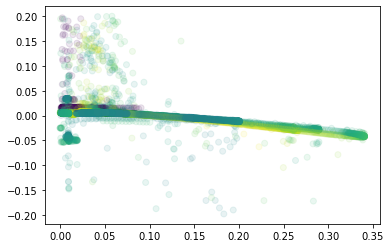

In [4]:
data = maptag_data
# data = runkey_data
# data = all_data

df = pd.json_normalize(data.json())

# Example: Graph of acceleration at different slide angles

## Preprocess: 

# Acceleration isn't natively provided - do .diff() for this for the derivative.
# Make sure to divide by the time quantity 'dt'.
df["acc"] = df["speed"].diff() / df["dt"]

## Filter:

df = df[abs(df["acc"]) < 0.2]

# Use this type of call to see what surfaces are available
print(df["frGroundContactMaterial"].unique())

# Example: If you want to see what the acceleration curve looks like for ice, between 40 and 60 m/s: 
# df = df[df["speed"] > 40]
# df = df[df["speed"] < 60]

selected_material = "Asphalt"

df = df[df["flGroundContactMaterial"] == selected_material]
df = df[df["frGroundContactMaterial"] == selected_material]
df = df[df["rlGroundContactMaterial"] == selected_material]
df = df[df["rrGroundContactMaterial"] == selected_material]

## Now scatter the data 
plt.scatter(x=df["slipDir"], y=df["acc"], c=df["speed"], alpha=0.1)
plt.show()

# Usage Example: Deriving ideal tarmac speedslide curve

For a workable example, here's exactly how to derive the ideal tarmac speedslide curve.

This method is based around finding the slip angle for each given speed that produces the highest acceleration. 

Note that the 'base' acceleration here is comparing against the baseline acceleration the car experiences with no sliding at all.

In [85]:
# This is the profile for plastic and road. 
# Grass and dirt are similar, except for a uniform 10% reduction 
# source: https://www.youtube.com/watch?v=KfMIT5cbO2g&t=260s

# Format: 
# [(start_speed, acc), ...]

# Unit here is km/h, km/h/s 
BASE_ACCEL_RAW = [
    (100, 57),
    (200, 40),
    (400, 25),
    (1000, 20)
]

# Transforms this into meters/second, meters/second/second 
BASE_ACCEL_MS = list(map(lambda x: (x[0] / 3.6, x[1] / 3600), BASE_ACCEL_RAW))

def analyze_fs_df(df, minv=400, maxv=999, is_slow_surface=False, mode="MAX", max_acc_percentile=99.5):
    if mode not in ("MAX", "BASE", "ZERO", "MIN"):
        raise ValueError("Error: Mode should be 'MAX', 'MIN', 'BASE', or 'ZERO'")
        
    df = df[df["speed"] > (minv / 3.6)]
    df = df[df["speed"] < (maxv / 3.6)].copy()
    
    # Set the 'base' acceleration for each row. This is how fast the car would accelerate without sliding.
    df["base_accel"] = df["speed"].apply(lambda val: next(filter(lambda tup: tup[0] > val, BASE_ACCEL_MS))[1])
    
    # Use rolling average of acceleration instead of raw 
    df["acc_rolling"] = df["acc"].rolling(1).mean()
    
    # Sidespeed is easier to work with than raw angles - this is really just a conventional choice, though, so
    # it doesn't really matter. It's what I did for GCP :) 
    df["sidespeed"] = df["speed"] * np.sin(df["slipDir"])
    
    # Break into subgroups based on speed. 
    df["speed_group"] = pd.cut(df["speed"], 30)
    
    if is_slow_surface:
        df["base_accel"] *= 0.9

    max_acc = {}
    min_acc = {}
    for group in df["speed_group"].unique():
        max_acc[group] = np.percentile(df[df["speed_group"] == group]["acc_rolling"], max_acc_percentile)   
        min_acc[group] = np.percentile(df[df["speed_group"] == group]["acc_rolling"], 100 - max_acc_percentile)   
    
    # Now max-acc has a mapping of 'speed group' -> 'max acceleration for that speed group'. 
    
    # Normalize acceleration, so it's between 0 and 1 (approximately).
    df["acc_max_for_speed_group"] = df.apply(lambda row: max_acc[row["speed_group"]], axis=1)
    df["acc_min_for_speed_group"] = df.apply(lambda row: min_acc[row["speed_group"]], axis=1)
    df["acc_relative_base"] = df["acc"] / df["base_accel"]
    
    # Now filter, so we're only looking at the fastest accelerations.
    at_max_acc_df = df[df["acc"] > df["acc_max_for_speed_group"]]
    at_min_acc_df = df[df["acc"] < df["acc_min_for_speed_group"]]
    
#     plt.xlabel("Speed (in m/s)")
    plt.xlabel("Acceleration")
    
#     plt.ylabel("Sidespeed (in m/s)")
    plt.ylabel("Slip angle (in radians)")
    
#     plt.title(f"Side speed required by speed for {mode.title()} acceleration")
    plt.title("Acceleration vs angle, colored by speed")
    
        
    if mode == "MAX":
        result_df = at_max_acc_df
    elif mode == "MIN": 
        result_df = at_min_acc_df
    elif mode == "BASE":
        result_df = df[abs(1 - df["acc_relative_base"]) < 0.02]
    elif mode == "ZERO":
        result_df = df[abs(df["acc_normalized"]) < 0.01]
        
    
    # And from here, do manual analysis. Try to draw the line through the data that best represents it.
    plt.scatter(
        x=result_df["acc"], 
        y=result_df["slipDir"], 
        c=result_df["speed"],
        alpha=0.4
    )
    plt.style.use("dark_background")
    plt.show()
    
    # For analysis for GCP, we're not done here. We need: 
    # -> Max acceleration line 
    # -> Acceleration equal to baseline acceleration line
    # -> Zero acceleration line
    
    # Slice the dataframe accordingly to make these views, and then apply the same graphical analysis method. 

analyze_fs_df(df[df["slipDir"] < .7], minv=0, maxv=999, is_slow_surface=False, mode="MIN")


# Working Section 

This area of the notebook is my in-progress projects. This will be less refined than the examples above, and also I'm not going to put as much effort into commenting and explaining things. 

If you have any questions about anything in this area, feel free to reach out on Discord and I'll get back to you when I can. 

## Icy Wet Wood - Stadium

In [12]:
SELECTED_MAPTAG = 'wood - stadium - wet, icy'
data = requests.get(f"{SERVER_PATH}/out/data/tag", params={"tag": SELECTED_MAPTAG})
df = pd.json_normalize(data.json())

df["acc"] = df["speed"].diff() / df["dt"]

selected_material = "Wood"

df = df[df["flGroundContactMaterial"] == selected_material]
df = df[df["frGroundContactMaterial"] == selected_material]
df = df[df["rlGroundContactMaterial"] == selected_material]
df = df[df["rrGroundContactMaterial"] == selected_material]

df = df[df["flIcing01"] > 0]
df = df[df["frIcing01"] > 0]
df = df[df["rlIcing01"] > 0]
df = df[df["rrIcing01"] > 0]

df = df[abs(df["acc"]) < 0.2]

df = df.copy()

analyze_fs_df(df)

In [14]:
plt.scatter(x=df["slipDir"], y=df["acc"], c=df["speed"], alpha=0.1)
plt.xlabel("Slip (in radians)")
plt.ylabel("Acceleration (in m/s/ms)")
plt.title("Raw data - Wood")
plt.show()

## Animation

Use these cells for generating an animation of points based on speed. 

In [31]:
from celluloid import Camera
import ffmpeg

def animate_plot_all_points(df, X_COLUMN, Y_COLUMN, GROUP_COLUMN, groups=20, legend=True, alpha=0.3):
    fig = plt.figure(figsize=(15, 10), dpi=120)
    camera = Camera(fig)

    ax = fig.add_subplot(111)

    df = df.copy()

    cmap = {1: 'darkblue',
            2: 'slateblue',
            3: 'mediumpurple',
            4: 'violet',
            5: 'magenta'
           }

    df = df.drop_duplicates(subset=[X_COLUMN, Y_COLUMN, GROUP_COLUMN])

    if groups > 0:
        df["group"] = pd.cut(df[GROUP_COLUMN], groups)
    else:
        df["group"] = df[GROUP_COLUMN]

    for group in sorted(df["group"].unique()):
        _df = df[df["group"] == group]
        ax.scatter(x=_df[X_COLUMN], y=_df[Y_COLUMN], label=group, alpha=alpha)
        camera.snap()

    if legend:
        leg = ax.legend(prop={"size": 10})
        leg.set_title(GROUP_COLUMN, prop={'size':10})

    plt.xlabel(X_COLUMN, fontsize=18)
    plt.ylabel(Y_COLUMN, fontsize=18)
    plt.show()

    anim = camera.animate(blit=False)
    anim.save("animation.gif", fps=10, dpi=200)

animate_plot_all_points(df, "slipDir", "acc", "speed")

MovieWriter ffmpeg unavailable; using Pillow instead.


# Rice and Dice

In [174]:
SELECTED_MAPTAG = 'ice - rally'
data = requests.get(f"{SERVER_PATH}/out/data/tag", params={"tag": SELECTED_MAPTAG})
df = pd.json_normalize(data.json())

df["acc"] = df["speed"].diff() / df["dt"]
df["slipDiff"] = df["slipDir"].diff() / df["dt"]
df["sidespeed"] = df["speed"] * np.sin(df["slipDir"])

df = df[df["inputGas"] == 1]

df = df[abs(df["acc"]) < 0.01]

df = df[abs(df["slipDiff"]) < 0.03]

print(df.columns)

selected_material = "RoadIce"

df = df[df["flGroundContactMaterial"] == selected_material]
df = df[df["frGroundContactMaterial"] == selected_material]
df = df[df["rlGroundContactMaterial"] == selected_material]
df = df[df["rrGroundContactMaterial"] == selected_material]

# df = df[abs(df["acc"]) < 0.0001]

df = df[df["slipDir"] < 1]
df = df[df["slipDir"] > 0.8]
df = df[df["acc"] < -0.0030]

plt.xlabel("Slip, in radians")
# plt.xlabel("Speed, in m/s")
# plt.ylabel("Acceleration, in m/s/ms")
# plt.title("Acceleration of Rally Car on Ice, by slide angle")
plt.ylabel("Sidespeed, in m/s")
# plt.title("Acceleration of Rally Car on Ice, by speed. Color is slip angle")
plt.title("Sidespeed by slip, rally, ice. Color is speed")
plt.scatter(x=df["speed"], y=df["sidespeed"], c=df["slipDir"], alpha=0.3)
plt.show()


Index(['pidx', 'runId', 'respawnId', 'username', 'version', 'vehicleType',
       'speed', 'frontSpeed', 'inputSteer', 'inputBrake', 'inputGas',
       'slipDir', 'slipLeft', 'curGear', 'flGroundContactMaterial',
       'frGroundContactMaterial', 'rlGroundContactMaterial',
       'rrGroundContactMaterial', 'flIcing01', 'frIcing01', 'rlIcing01',
       'rrIcing01', 'reactor', 'time', 'dt', 'acc', 'slipDiff', 'sidespeed'],
      dtype='object')
